In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# DATA GENERATION

In [221]:
WIDTH = 5
HEIGHT = 500

sample_data = [[(i+j)/(i+1) for i in range(WIDTH)] for j in range(HEIGHT)]

names = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
column_names = [names[i] for i in range(WIDTH-1)] + ["TARGET"]
orig_data = pd.DataFrame(sample_data)

orig_data.columns = column_names

print(orig_data.head())

     A    B         C     D  TARGET
0  0.0  0.5  0.666667  0.75     0.8
1  1.0  1.0  1.000000  1.00     1.0
2  2.0  1.5  1.333333  1.25     1.2
3  3.0  2.0  1.666667  1.50     1.4
4  4.0  2.5  2.000000  1.75     1.6


DATA SPLITTING

In [222]:
dataset = orig_data.copy()
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('TARGET')
test_labels = test_features.pop('TARGET')

Adding the Normalizer

In [223]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

Sequential Model (Deep Neural Network)

In [235]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,     
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

AttributeError: 'Normalization' object has no attribute 'shape'

Early Stopping Mechanism

In [225]:
early_stopping = keras.callbacks.EarlyStopping(
    patience = 5,
    min_delta = 0.001,
    restore_best_weights = True
)

Fit the model to the train features (X) and train labels (Y)

In [226]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_data = (test_features, test_labels),
    verbose=1, 
    callbacks = [early_stopping],
    epochs=100)

Epoch 1/100
13/13 [==============================] - 12s 424ms/step - loss: 49.9529 - val_loss: 52.2635
Epoch 2/100
13/13 [==============================] - 6s 485ms/step - loss: 49.3003 - val_loss: 51.3701
Epoch 3/100
13/13 [==============================] - 2s 145ms/step - loss: 48.1657 - val_loss: 49.4731
Epoch 4/100
13/13 [==============================] - 3s 286ms/step - loss: 46.0495 - val_loss: 46.2194
Epoch 5/100
13/13 [==============================] - 2s 160ms/step - loss: 42.5236 - val_loss: 40.9516
Epoch 6/100
13/13 [==============================] - 2s 194ms/step - loss: 37.0501 - val_loss: 32.2454
Epoch 7/100
13/13 [==============================] - 2s 177ms/step - loss: 26.7364 - val_loss: 16.8258
Epoch 8/100
13/13 [==============================] - 2s 174ms/step - loss: 18.0768 - val_loss: 18.2470
Epoch 9/100
13/13 [==============================] - 2s 176ms/step - loss: 16.7715 - val_loss: 14.7791
Epoch 10/100
13/13 [==============================] - 2s 183ms/step - lo

Loss Curve

Minimum Validation Loss: 0.1153


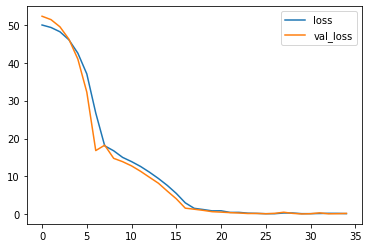

In [227]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

plt.show()

Prediction Curve

4/4 [==============================] - 7s 5ms/step


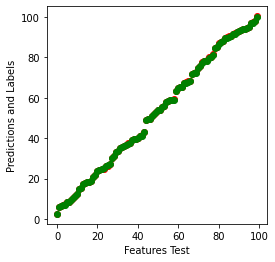

In [228]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(range(len(test_labels)), test_labels, color="red")
plt.scatter(range(len(test_labels)), test_predictions, color="green")
plt.xlabel('Features Test')
plt.ylabel('Predictions and Labels')

plt.show()

Evaluate Accuracy

In [229]:
test_labels_copy = test_labels.copy()

predict_df = pd.DataFrame(test_predictions, columns=["PREDICTED"])
predict_df.index = test_labels_copy.index

accuracy_df = pd.concat([test_features, test_labels, predict_df], axis=1)
accuracy_df["Accuracy"] = accuracy_df.PREDICTED/accuracy_df.TARGET
accuracy_df.Accuracy.describe()

count    100.000000
mean       0.998207
std        0.004052
min        0.968347
25%        0.997106
50%        0.998285
75%        0.999839
max        1.005642
Name: Accuracy, dtype: float64

FURTHER ACCURACY TEST

In [231]:
WIDTH = 5
REFERENCE_HEIGHT = HEIGHT
TEST_HEIGHT = 500


test_accuracy_data = [[(i+j)/(i+1) for i in range(WIDTH)] for j in range(REFERENCE_HEIGHT, REFERENCE_HEIGHT + TEST_HEIGHT)]

names = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
column_names = [names[i] for i in range(WIDTH-1)] + ["TARGET"]
test_accuracy_data = pd.DataFrame(test_accuracy_data)

test_accuracy_data.columns = column_names

print(test_accuracy_data.head())

       A      B           C       D  TARGET
0  500.0  250.5  167.333333  125.75   100.8
1  501.0  251.0  167.666667  126.00   101.0
2  502.0  251.5  168.000000  126.25   101.2
3  503.0  252.0  168.333333  126.50   101.4
4  504.0  252.5  168.666667  126.75   101.6


Predict using the model

16/16 [==============================] - 5s 4ms/step


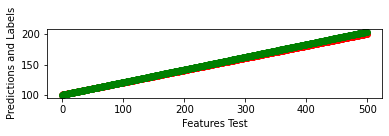

In [232]:
test_features2 = test_accuracy_data.copy()
test_labels2 = test_features2.pop('TARGET')

test_predictions2 = dnn_model.predict(test_features2).flatten()

a = plt.axes(aspect='equal')
plt.scatter(range(len(test_labels2)), test_labels2, color="red")
plt.scatter(range(len(test_labels2)), test_predictions2, color="green")
plt.xlabel('Features Test')
plt.ylabel('Predictions and Labels')

plt.show()

Accuracy Level 2

In [ ]:
test_labels2_copy = test_labels2.copy()

predict2_df = pd.DataFrame(test_predictions2, columns=["PREDICTED"])
predict2_df.index = test_labels2_copy.index

accuracy2_df = pd.concat([test_features2, test_labels2, predict2_df], axis=1)
accuracy2_df["Accuracy"] = accuracy2_df.PREDICTED/accuracy2_df.TARGET
accuracy2_df.Accuracy.describe()

Save Model

In [ ]:
#dnn_model.save('DNN_TEST_MODEL')